# Cluster headache simulations: Streamlined full model

In [1]:
import numpy as np
from scipy.stats import lognorm, gmean, rv_discrete, beta, truncnorm, expon
from scipy.optimize import minimize, curve_fit
import warnings
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import streamlit as st

## Global statistics

In [2]:
# Define the overall population
annual_prevalence = 53/100000 # 53 per 100,000 (95% CI: 26, 95) of adults
world_population = 8_200_000_000
adult_fraction = 0.72
total_ch_sufferers = world_population * adult_fraction * annual_prevalence # Estimated global CH sufferers

# Define the proportions for each group
prop_episodic = 0.80
prop_chronic = 1 - prop_episodic
prop_treated = 0.48
prop_untreated = 1 - prop_treated

# Define the groups
ch_groups = {
    'Episodic Treated': int(total_ch_sufferers * prop_episodic * prop_treated),
    'Episodic Untreated': int(total_ch_sufferers * prop_episodic * prop_untreated),
    'Chronic Treated': int(total_ch_sufferers * prop_chronic * prop_treated),
    'Chronic Untreated': int(total_ch_sufferers * prop_chronic * prop_untreated)
}

## Annual bout frequency for episodic patients

In [3]:
data = {
    # Discretized approximation for a distribution with mean 1.2, SD 1.1
    'Gaul': {'n': 209, 'dist': {1: 0.6, 2: 0.3, 3: 0.1}},  
    
    # Split "<1/year" between 0 and 1, ">1/year" between 2 and 3
    'Li': {'n': 327, 'dist': {0.5: 0.416, 1: 0.370, 2.5: 0.214}},
    
    # Split "1/1.5-2 years" between 0 and 1
    'Friedman': {'n': 50, 'dist': {0.5: 0.46, 1: 0.54}},
    
    # Split "<1/year" between 0 and 1
    'Ekbom': {'n': 105, 'dist': {0.5: 0.14, 1: 0.40, 2: 0.31, 3: 0.15}},
    
    # Split "1-2/year" evenly between 1 and 2
    'Manzoni': {'n': 161, 'dist': {1: 0.27, 1.5: 0.73}},
    
    # Converted from remission periods to bouts/year, chronic cases removed
    'Sutherland': {'n': 49, 'dist': {
        0.5: 0.512+0.174,  # 1-5 years, adding >5 years for simplicity
        1: 0.140,    # 6-12 months
        2: 0.174     # 3-6 months
    }},
    
    # Estimated from remission periods, splitting some categories
    'Kudrow': {'n': 428, 'dist': {0.5: 0.19, 1: 0.67, 2.5: 0.14}}
}

# Combine distributions
combined_dist = {}
total_n = sum(study['n'] for study in data.values())

for study in data.values():
    weight = study['n'] / total_n
    for bouts, prob in study['dist'].items():
        combined_dist[bouts] = combined_dist.get(bouts, 0) + prob * weight

# Normalize the combined distribution
total_prob = sum(combined_dist.values())
combined_dist = {k: v/total_prob for k, v in combined_dist.items()}

# Create custom discrete distribution
bouts_per_year = rv_discrete(values=(list(combined_dist.keys()), list(combined_dist.values())))

## Bout duration for episodic patients

In [13]:
data = []
sample_sizes = []

# Gaul et al. (2012)
data.append(8.5)
sample_sizes.append(209)

# Li et al. (2022)
total_li = 327
original_proportions = np.array([0.104, 0.235, 0.502, 0.131])
sum_proportions = np.sum(original_proportions)
new_proportions = original_proportions / sum_proportions
data.extend([1, gmean([2, 4]), gmean([4, 8]), 8])
sample_sizes.extend([int(prop * total_li) for prop in new_proportions])

# Friedman & Mikropoulos (1958)
data.append(gmean([6, 8]))
sample_sizes.append(50)

# Ekbom (1970)
data.append(gmean([4, 12]))
sample_sizes.append(105)

# Lance & Anthony (1971)
data.append(gmean([2, 12]))
sample_sizes.append(60)

# Sutherland & Eadie (1972)
total_sutherland = 58
data.extend([np.mean([0, 4]), gmean([5, 13]), gmean([14, 26]), gmean([27, 52])])
sample_sizes.extend([int(0.23 * total_sutherland), int(0.45 * total_sutherland), 
                     int(0.19 * total_sutherland), int(0.14 * total_sutherland)])

# Rozen & Fishman (2012)
data.append(10.3)
sample_sizes.append(101)

# Manzoni et al. (1983)
data.append(gmean([4, 8]))
sample_sizes.append(161)

# Convert to numpy arrays
data = np.array(data)
sample_sizes = np.array(sample_sizes)

# Use sample sizes as weights
weights = sample_sizes / np.sum(sample_sizes)

# Fitting the lognormal distribution
def neg_log_likelihood(params):
    mu, sigma = params
    return -np.sum(weights * lognorm.logpdf(data, s=sigma, scale=np.exp(mu)))

initial_params = [np.log(np.average(data, weights=weights)), 0.5]
result = minimize(neg_log_likelihood, initial_params, method='Nelder-Mead')
optimal_mu, optimal_sigma = result.x

## Modeling attacks per day for both episodic and chronic CH sufferers

In [16]:
def fit_lognormal(mean, std):
    """
    Fit a lognormal distribution given mean and standard deviation.
    Returns the mu and sigma parameters of the lognormal distribution.
    """
    variance = std**2
    mu = np.log(mean**2 / np.sqrt(variance + mean**2))
    sigma = np.sqrt(np.log(1 + variance / mean**2))
    return mu, sigma

def truncated_lognorm_pdf(x, mu, sigma, upper_bound=np.inf):
    """
    Calculate the PDF of a truncated lognormal distribution.
    """
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    cdf_upper = lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu))
    return np.where(x <= upper_bound, pdf / cdf_upper, 0)

def estimate_untreated(treated_mean, treated_std, treatment_effect=1.05):
    """
    Function to estimate untreated values
    """
    cv = treated_std / treated_mean  # Coefficient of variation
    untreated_mean = treated_mean * treatment_effect
    untreated_std = untreated_mean * cv
    return untreated_mean, untreated_std

def generate_attacks_per_day(is_chronic, is_treated, max_daily_ch=np.inf):
    if is_chronic:
        if is_treated:
            mu, sigma = chronic_treated_mu, chronic_treated_sigma
        else:
            mu, sigma = chronic_untreated_mu, chronic_untreated_sigma
    else:
        if is_treated:
            mu, sigma = episodic_treated_mu, episodic_treated_sigma
        else:
            mu, sigma = episodic_untreated_mu, episodic_untreated_sigma
    
    while True:
        attacks = lognorm.rvs(s=sigma, scale=np.exp(mu))
        if attacks <= max_daily_ch:
            break
    
    return max(1, round(attacks))

# Gaul et al. (2012) data for treated patients (not explicitly stated in the paper,
# but highly likely given that they were German patients from a hospital)
episodic_treated_mean, episodic_treated_std = 3.1, 2.1
chronic_treated_mean, chronic_treated_std = 3.3, 3.0

# Estimating untreated values
episodic_untreated_mean, episodic_untreated_std = estimate_untreated(episodic_treated_mean, episodic_treated_std)
chronic_untreated_mean, chronic_untreated_std = estimate_untreated(chronic_treated_mean, chronic_treated_std)

# Fit lognormal distributions
episodic_treated_mu, episodic_treated_sigma = fit_lognormal(episodic_treated_mean, episodic_treated_std)
chronic_treated_mu, chronic_treated_sigma = fit_lognormal(chronic_treated_mean, chronic_treated_std)
episodic_untreated_mu, episodic_untreated_sigma = fit_lognormal(episodic_untreated_mean, episodic_untreated_std)
chronic_untreated_mu, chronic_untreated_sigma = fit_lognormal(chronic_untreated_mean, chronic_untreated_std)

## Simulating active days for chronic patients

In [19]:
def generate_chronic_active_days():
    while True:
        # Generate total attack days in a year
        active_days = int(lognorm.rvs(s=.5, scale=np.exp(np.log(200))))
        
        # Ensure active_days is never over 365
        active_days = min(active_days, 365)
        
        return active_days

## Simulating attack durations

In [20]:
def generate_attack_duration(is_chronic, is_treated, max_intensities, size):
    # Base parameters for lognormal distribution
    mu = 4.0
    sigma = 0.4
    
    if is_chronic:
        mu += 0.3  # Slightly longer attacks for chronic sufferers
    
    # Generate base durations
    base_durations = lognorm.rvs(s=sigma, scale=np.exp(mu), size=size)
    
    # Adjust durations based on max intensities
    # This creates a positive correlation between intensity and duration
    intensity_factor = 0.1064 * max_intensities + 0.5797 # Scale factor based on intensity
    adjusted_durations = base_durations * intensity_factor

    if is_treated:
        # Reasoning: Patients with access to treatment will, in some cases, manage to reduce
        # the duration of the attack. However, according to Snoer et al., mild attacks are often
        # not treated despite having access to treatment, and those are typically shorter, which explains
        # the seemingly contradictory statistic about untreated attacks being shorter.
        
        max_effect = 0.3  # Up to 30% duration reduction for highest intensity
        
        intensity_normalized = (max_intensities - 1) / 9
        
        # The more intense the attack, the more a patient will use treatment to abort the attack (shorter duration)
        mean_effect = 1 - (max_effect * intensity_normalized)
        
        # However, treatment might or might not be effective, so model this using a beta distribution.
        a, b = 5, 2
        treatment_effect = beta.rvs(a, b, size=size) * mean_effect
        
        # Apply treatment effect
        adjusted_durations *= treatment_effect
    
    return np.clip(np.round(adjusted_durations).astype(int), 15, 360)

## Simulating max pain intensity

In [21]:
def generate_max_pain_intensity(is_treated, size):
    
    mean_mild_moderate = 4.0
    sd_mild_moderate = 2.0
    mean_moderate_severe = 7.5
    sd_moderate_severe = 2.0
    scale_very_severe = .7 if is_treated else 0.5
    
    mild_to_moderate = truncnorm.rvs((1-mean_mild_moderate)/sd_mild_moderate, np.inf, loc=mean_mild_moderate, scale=sd_mild_moderate, size=size)
    moderate_to_severe = truncnorm.rvs((1-mean_moderate_severe)/sd_moderate_severe, np.inf, loc=mean_moderate_severe, scale=sd_moderate_severe, size=size)
    very_severe = 10 - expon.rvs(scale=scale_very_severe, size=size)
    
    if is_treated:
        # For treated patients:
        choices = np.random.choice(3, size=size, p=[0.40, 0.35, 0.25])
    else:
        # For untreated patients:
        choices = np.random.choice(3, size=size, p=[0.20, 0.50, 0.30])

    intensities = np.where(choices == 0, mild_to_moderate,
                  np.where(choices == 1, moderate_to_severe, very_severe))
    
    return np.round(np.clip(intensities, 1, 10), decimals=1)

## Defining classes for attacks and patients

In [22]:
@dataclass
class Attack:
    total_duration: int
    max_intensity: float
    max_intensity_duration: int

class Patient:
    def __init__(self, is_chronic, is_treated):
        self.is_chronic = is_chronic
        self.is_treated = is_treated
        self.attacks = []
        self.generate_profile()
        self.pre_generate_attack_pool()

    def generate_profile(self):
        if self.is_chronic:
            self.active_days = generate_chronic_active_days()
        else:
            self.annual_bouts = bouts_per_year.rvs()
            self.bout_durations = self.generate_bout_durations()

    def pre_generate_attack_pool(self):
        # Estimate the maximum number of attacks in a year
        if self.is_chronic:
            max_attacks = self.active_days * 8  # Assuming max 8 attacks per day
        else:
            max_attacks = sum(self.bout_durations) * 8

        # Generate a pool of attacks
        max_intensities = generate_max_pain_intensity(is_treated=self.is_treated, size=max_attacks)
        total_durations = generate_attack_duration(self.is_chronic, self.is_treated, max_intensities, size=max_attacks)
        # Assuming onset and offset phases take up 15% of the total attack duration each
        max_intensity_durations = np.round(0.7 * total_durations).astype(int)

        self.attack_pool = [Attack(total_durations[i], max_intensities[i], max_intensity_durations[i])
                            for i in range(max_attacks)]
        self.pool_index = 0
        
    def generate_bout_durations(self):
        # Use the lognormal distribution for bout durations
        n_bouts = np.ceil(self.annual_bouts)
        durations = lognorm.rvs(s=optimal_sigma, scale=np.exp(optimal_mu), size=int(n_bouts))
        
        # Adjust the last bout duration if annual_bouts is not an integer
        if self.annual_bouts != int(self.annual_bouts):
            durations[-1] *= (self.annual_bouts - int(self.annual_bouts))
        
        return [max(1, int(duration * 7)) for duration in durations]  # Convert weeks to days, ensure at least 1 day

    def generate_year_of_attacks(self):
        self.attacks = []
        total_attacks = 0
        if self.is_chronic:
            for day in range(min(365, self.active_days)):
                total_attacks += self.generate_day_attacks()
        else:
            for duration in self.bout_durations:
                for day in range(duration):
                    total_attacks += self.generate_day_attacks()
        return total_attacks

    def generate_day_attacks(self):
        daily_attacks = 0
        attacks_today = generate_attacks_per_day(self.is_chronic, self.is_treated)

        for _ in range(attacks_today):
            if self.pool_index >= len(self.attack_pool):
                # If we've used all pre-generated attacks, generate more
                self.pre_generate_attack_pool()
            
            self.attacks.append(self.attack_pool[self.pool_index])
            self.pool_index += 1
            daily_attacks += 1

        return daily_attacks

    def calculate_intensity_minutes(self):
        intensity_minutes = {}
        for attack in self.attacks:
            intensity = round(attack.max_intensity, 1)  # Round to nearest 0.1
            intensity_minutes[intensity] = intensity_minutes.get(intensity, 0) + attack.max_intensity_duration
        return intensity_minutes

## Running some simulations

Episodic Treated: N=120
Attacks - Mean: 206, Median: 158, IQR: [98, 274]
Intensity - Mean: 6.9, Median: 7.3, IQR: [4.9, 9.3]

Episodic Untreated: N=130
Attacks - Mean: 179, Median: 140, IQR: [82, 264]
Intensity - Mean: 7.8, Median: 8.6, IQR: [6.4, 9.7]

Chronic Treated: N=30
Attacks - Mean: 700, Median: 624, IQR: [485, 942]
Intensity - Mean: 6.9, Median: 7.4, IQR: [4.9, 9.3]

Chronic Untreated: N=32
Attacks - Mean: 761, Median: 750, IQR: [512, 1072]
Intensity - Mean: 7.9, Median: 8.7, IQR: [6.4, 9.7]


Aggregate Statistics:
All Treated: N=150
Attacks - Mean: 304, Median: 203, IQR: [108, 407]
Intensity - Mean: 6.9, Median: 7.3, IQR: [4.9, 9.3]

All Untreated: N=162
Attacks - Mean: 294, Median: 181, IQR: [91, 358]
Intensity - Mean: 7.9, Median: 8.7, IQR: [6.4, 9.7]

All Episodic: N=250
Attacks - Mean: 192, Median: 149, IQR: [87, 269]
Intensity - Mean: 7.5, Median: 8.2, IQR: [5.8, 9.6]

All Chronic: N=62
Attacks - Mean: 731, Median: 676, IQR: [512, 970]
Intensity - Mean: 7.6, Median: 8.3,

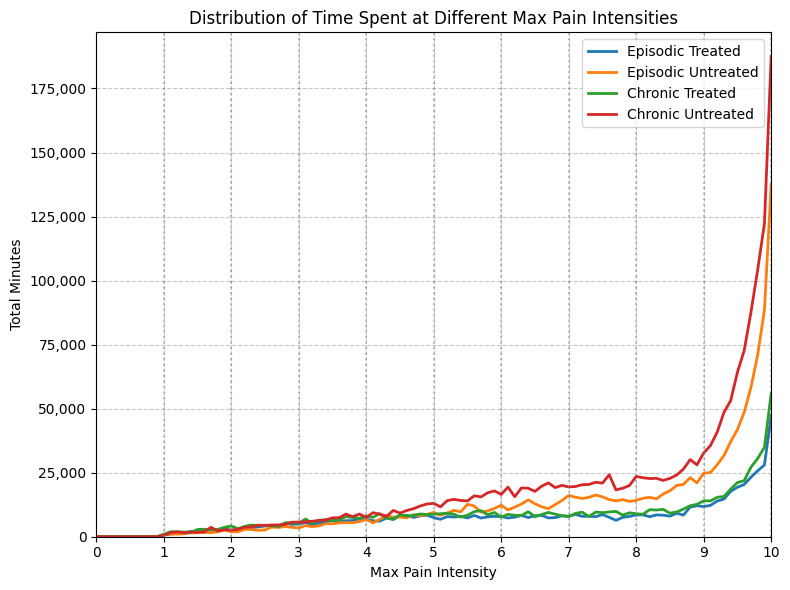

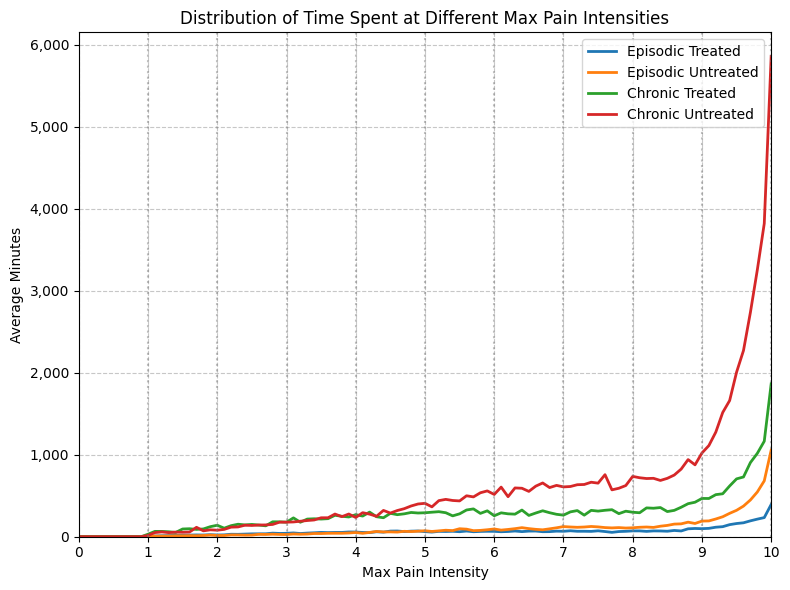

In [27]:
def generate_population(n_episodic_treated, n_episodic_untreated, n_chronic_treated, n_chronic_untreated):
    population = []
    for _ in range(n_episodic_treated):
        population.append(Patient(is_chronic=False, is_treated=True))
    for _ in range(n_episodic_untreated):
        population.append(Patient(is_chronic=False, is_treated=False))
    for _ in range(n_chronic_treated):
        population.append(Patient(is_chronic=True, is_treated=True))
    for _ in range(n_chronic_untreated):
        population.append(Patient(is_chronic=True, is_treated=False))
    return population

# Generate the population to simulate
fraction_of_patients_to_simulate = .0001

n_episodic_treated = int(ch_groups['Episodic Treated'] * fraction_of_patients_to_simulate)
n_episodic_untreated = int(ch_groups['Episodic Untreated'] * fraction_of_patients_to_simulate)
n_chronic_treated = int(ch_groups['Chronic Treated'] * fraction_of_patients_to_simulate)
n_chronic_untreated = int(ch_groups['Chronic Untreated'] * fraction_of_patients_to_simulate)

population = generate_population(n_episodic_treated, n_episodic_untreated, n_chronic_treated, n_chronic_untreated)

def calculate_group_data(population, groups_simulated):
    intensities = np.arange(0, 10.1, 0.1)
    group_data = []
    chronic_attacks = []
    episodic_attacks = []
    
    all_treated_attacks = []
    all_untreated_attacks = []
    all_episodic_attacks = []
    all_chronic_attacks = []
    all_treated_intensities = []
    all_untreated_intensities = []
    all_episodic_intensities = []
    all_chronic_intensities = []

    for group_name, condition, n_patients in groups_simulated:
        group_patients = [p for p in population if condition(p)]
        total_intensity_minutes = {}
        group_total_attacks = []
        group_intensities = []
        
        for patient in group_patients:
            total_attacks = patient.generate_year_of_attacks()
            group_total_attacks.append(total_attacks)
            
            patient_intensity_minutes = patient.calculate_intensity_minutes()
            for intensity, minutes in patient_intensity_minutes.items():
                total_intensity_minutes[intensity] = total_intensity_minutes.get(intensity, 0) + minutes
                group_intensities.extend([intensity] * int(minutes))
        
        intensity_minutes_average = [total_intensity_minutes.get(round(i, 1), 0) / n_patients for i in intensities]
        intensity_minutes_total = [total_intensity_minutes.get(round(i, 1), 0) for i in intensities]
        group_data.append((group_name, intensity_minutes_average, intensity_minutes_total, n_patients))
        
        # Calculate statistics
        attack_stats = np.percentile(group_total_attacks, [25, 50, 75])
        intensity_stats = np.percentile(group_intensities, [25, 50, 75])
        
        print(f"{group_name}: N={n_patients}")
        print(f"Attacks - Mean: {np.mean(group_total_attacks):.0f}, Median: {attack_stats[1]:.0f}, IQR: [{attack_stats[0]:.0f}, {attack_stats[2]:.0f}]")
        print(f"Intensity - Mean: {np.mean(group_intensities):.1f}, Median: {intensity_stats[1]:.1f}, IQR: [{intensity_stats[0]:.1f}, {intensity_stats[2]:.1f}]")
        print()
        
        if 'Chronic' in group_name:
            chronic_attacks.extend(group_total_attacks)
            all_chronic_attacks.extend(group_total_attacks)
            all_chronic_intensities.extend(group_intensities)
        else:
            episodic_attacks.extend(group_total_attacks)
            all_episodic_attacks.extend(group_total_attacks)
            all_episodic_intensities.extend(group_intensities)
        
        if 'Treated' in group_name:
            all_treated_attacks.extend(group_total_attacks)
            all_treated_intensities.extend(group_intensities)
        else:
            all_untreated_attacks.extend(group_total_attacks)
            all_untreated_intensities.extend(group_intensities)
    
    # Print aggregate statistics
    print("\nAggregate Statistics:")
    print_aggregate_stats("All Treated", all_treated_attacks, all_treated_intensities)
    print_aggregate_stats("All Untreated", all_untreated_attacks, all_untreated_intensities)
    print_aggregate_stats("All Episodic", all_episodic_attacks, all_episodic_intensities)
    print_aggregate_stats("All Chronic", all_chronic_attacks, all_chronic_intensities)
    
    return intensities, group_data

def print_aggregate_stats(group_name, attacks, intensities):
    attack_stats = np.percentile(attacks, [25, 50, 75])
    intensity_stats = np.percentile(intensities, [25, 50, 75])
    print(f"{group_name}: N={len(attacks)}")
    print(f"Attacks - Mean: {np.mean(attacks):.0f}, Median: {attack_stats[1]:.0f}, IQR: [{attack_stats[0]:.0f}, {attack_stats[2]:.0f}]")
    print(f"Intensity - Mean: {np.mean(intensities):.1f}, Median: {intensity_stats[1]:.1f}, IQR: [{intensity_stats[0]:.1f}, {intensity_stats[2]:.1f}]")
    print()
    
def plot_data(intensities, group_data, y_label, title):
    plt.figure(figsize=(8, 6))
    for group_name, intensity_minutes, _, _ in group_data:
        plt.plot(intensities, intensity_minutes, label=group_name, linewidth=2)
    
    plt.xlabel('Max Pain Intensity')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 10)
    plt.ylim(bottom=0)
    plt.xticks(range(11))
    
    for i in range(1, 11):
        plt.axvline(x=i, color='gray', linestyle=':', alpha=0.5)
    
    # Format y-axis ticks with commas
    def format_with_commas(x, p):
        return f"{int(x):,}"
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_commas))
    
    plt.tight_layout()
    plt.show()

groups_simulated = [
    ("Episodic Treated", lambda p: not p.is_chronic and p.is_treated, n_episodic_treated),
    ("Episodic Untreated", lambda p: not p.is_chronic and not p.is_treated, n_episodic_untreated),
    ("Chronic Treated", lambda p: p.is_chronic and p.is_treated, n_chronic_treated),
    ("Chronic Untreated", lambda p: p.is_chronic and not p.is_treated, n_chronic_untreated)
]

# Calculate group data and print results
intensities, group_data = calculate_group_data(population, groups_simulated)

# Plot total minutes
plot_data(intensities, [(name, total, _, _) for name, _, total, _ in group_data], 
          'Total Minutes', 'Distribution of Time Spent at Different Max Pain Intensities')

# Plot average minutes
plot_data(intensities, [(name, avg, _, _) for name, avg, _, _ in group_data], 
          'Average Minutes', 'Distribution of Time Spent at Different Max Pain Intensities')